<a href="https://colab.research.google.com/github/blufzzz/two-stream-dyntex-synth/blob/spatio-temporal-statistics/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here is experiments with approach described in 

http://arxiv.org/abs/1702.07006   


In [0]:
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

In [0]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [3]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


In [0]:
import os
import sys
import re
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import datetime
from scipy.optimize import minimize
import tensorflow as tf
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth/src') 
from utilities import load_image, load_images, vgg_process, vgg_deprocess, check_snapshots
from appearance_descriptor import AppearanceDescriptor
from optimizer import Optimizer

from IPython.core.debugger import set_trace

# Optimizer

In [0]:
class Optimizer(object):

    def __init__(self, graph, input_dimension, input_frame_count,
                 target_dynamic_path, target_static_path, config):
        self.graph = graph
        self.input_dimension = input_dimension
        self.input_frame_count = input_frame_count
        self.target_dynamic_path = target_dynamic_path
        self.target_static_path = target_static_path
        self.user_config = config['user']
        self.tf_config = config['tf']
        self.iterations_so_far = 0

    def print_info(self, losses):
        i = self.iterations_so_far
        iterations = self.user_config['iterations']
        run_id = self.user_config['run_id']

        time_diff = time.time() - self.last_print
        it_per_sec = 1 / time_diff
        remaining_it = iterations - i
        eta = remaining_it / it_per_sec
        eta_string = str(datetime.timedelta(seconds=eta))

        print_string = '(%s) Iteration %d: dynamic texture loss: %f ' \
                       'iter per/s: %f ETA: %s' % (run_id, i + 1,losses[0],
                                                   it_per_sec, eta_string)
        print print_string
        self.last_print = time.time()

    def minimize_callback(self, dyntex_loss, output, summaries):
        # if hasattr(self, 'current_loss'):
        #     self.past_loss = self.current_loss
        # self.current_loss = dyntex_loss
        # for cleanliness
        i = self.iterations_so_far
        snapshot_frequency = self.user_config['snapshot_frequency']
        network_out_frequency = self.user_config['network_out_frequency']
        log_frequency = self.user_config['log_frequency']
        run_id = self.user_config['run_id']

        # print training information
        self.print_info([dyntex_loss])

        if (i + 1) % snapshot_frequency == 0:
            print 'Saving snapshot...'
            try:
                os.makedirs('snapshots/' + run_id)
            except OSError:
                if not os.path.isdir('snapshots/' + run_id):
                    raise
            self.saver.save(self.sess, 'snapshots/' + run_id + '/iter',
                            global_step=i+1)
            
        if (i + 1) % log_frequency == 0:
            print 'Saving log file...'
            self.summary_writer.add_summary(summaries, i + 1)
            self.summary_writer.flush()

        if (i + 1) % network_out_frequency == 0:
    
            print 'Saving image(s)...'
            try:
                os.makedirs('data/out/' + run_id)
            except OSError:
                if not os.path.isdir('data/out/' + run_id):
                    raise
                    
            network_out = output #.reshape((-1,self.input_dimension,
                                                      #    self.input_dimension, 3))
            
            img_out = vgg_deprocess(network_out[0], no_clip=False,
                                    unit_scale=False)
            
            # Showing
            plt.figure()
            plt.imshow(output[0])
            plt.title('Iter {0}, var {1}'.format(self.iterations_so_far, output[0].var() ))
            plt.grid(False)
            plt.show()
            
            plt.figure()
            plt.imshow(img_out)
            plt.title('after vgg_deproces, var{}'.format(img_out.var()))
            plt.grid(False)
            plt.show()
            
            if os.listdir('data/out/' + run_id):

                last_number = int(sorted([re.findall('\d+',imname)[-1]
                                      for imname in os.listdir('data/out/' + run_id)])[-1])

            else:    

                last_number = 0

            filename = 'data/out/' + run_id + \
                '/iter_%d_frame_%d.png'

            skimage.io.imsave(filename %
                              (i + 1, last_number + 1), img_out)

        self.iterations_so_far += 1

    def step_callback(self, args):
        if hasattr(self, 'past_loss'):
            loss_diff = (self.past_loss - self.current_loss) / \
                np.amax([np.abs(self.past_loss), np.abs(self.current_loss), 1])
            print 'f diff = ' + str(loss_diff)

    def optimize(self):
        iterations = self.user_config['iterations']
        run_id = self.user_config['run_id']

        with self.graph.as_default():
            """
            Instantiate optimizer
            """
            with tf.device('/gpu:' + str(self.user_config['gpu'])):
              
                optimizer = tf.contrib.opt.ScipyOptimizerInterface(	
                    self.dyntex_loss, 
                    var_list = [self.output],
                    method='L-BFGS-B',
                    var_to_bounds = [self.lower_bound, self.upper_bound],
                    options={'maxfun': iterations,
                             'disp': True,
                             'ftol': 0,
                             'gtol': 0})

            """
            Train over iterations, printing loss at each one
            """
            self.saver = tf.train.Saver(max_to_keep=0, pad_step_number=16)
            with tf.Session(config=self.tf_config) as self.sess:

                # TODO: change snapshot and log folders to be in a single
                # location
                # check snapshots
#                 resume, self.iterations_so_far = check_snapshots(run_id)
                self.iterations_so_far = 0
				        
                # start summary writer
                self.summary_writer = tf.summary.FileWriter('logs/' + run_id,
                                                          self.sess.graph)
                
#                 if resume:
#                     self.saver.restore(self.sess, resume)
#                 else:
                self.sess.run(tf.global_variables_initializer())
				
                # initialize start time
                self.last_print = time.time()

                # start train loop
                print '-------OPTIMIZING USING L-BFGS-B-------'
                # scipy optimizer needs a callback for printing iter info
                optimizer.minimize(self.sess,
                                   fetches=[self.dyntex_loss,
                                            self.output,
                                            self.summaries],
                                   loss_callback=self.minimize_callback)
                
                
    def minimize(self):
    
      with self.graph.as_default():
        with tf.device('/gpu:' + str(self.user_config['gpu'])):
          with tf.Session(config=self.tf_config) as self.sess:

            self.sess.run(tf.global_variables_initializer())

            opt = tf.train.AdamOptimizer()

            print ('start to optimize!')

            opt.minimize(self.dyntex_loss, var_list = [self.output])

# Synthesizer

In [0]:
class SpatialGramSynthesizer(Optimizer):
  
  def __init__(self, target_dynamic_path, generated_dynamic_path, dt, config):

    Optimizer.__init__(self, tf.Graph(), 256, 12, target_dynamic_path, '',config)
    
    self.dt = dt
    
    with self.graph.as_default():
      with tf.device('/gpu:' + str(self.user_config['gpu'])):

        imgs = load_images(target_dynamic_path,
                       size=(self.input_frame_count,
                             self.input_dimension,
                             self.input_dimension))
        
        self.target_dynamic_texture = [tf.to_float(
            tf.constant(img.reshape(1, self.input_dimension,
                                  self.input_dimension, 3)))
                                  for img in imgs]
        
        self.lower_bound = min([img.min() for img in imgs ])
        self.upper_bound = max([img.max() for img in imgs ])

#         try:
          
#           is_generated = len(os.listdir(generated_dynamic_path))
        
#         except OSError:
          
#           is_generated = False
        
#         if is_generated:
        
#           gen_imgs = load_images(generated_dynamic_path,
#                          size=(self.input_frame_count,
#                                self.input_dimension,
#                                self.input_dimension))
          
#           generated_dynamic_texture = [tf.to_float(
#             tf.constant(img.reshape(1, self.input_dimension,
#                                   self.input_dimension, 3)))
#                                   for img in gen_imgs]
          
#         else:
          
#           generated_dynamic_texture = []
            
        initial_noise = tf.random.normal([1,
                                          self.input_dimension,
                                          self.input_dimension, 3]) #, maxval = 128, minval = -128)    
        
        # Variable we'll optimize!
#         self.output = tf.Variable(tf.identity(self.target_dynamic_texture[-1]), name='output')
        self.output = tf.Variable(initial_noise, name='output')

                  
        # starting from the last (dt-1) frames we'll optimize new one (output)
        self.output_within_timeframe = self.target_dynamic_texture[-(self.dt-1):] + [self.output]

        self.dyntex_loss = self.build_spatial_gram_descriptors('spatial_gram_descriptors', 1e6)
        
        self.attach_summaries('summaries')

  def build_spatial_gram_descriptors(self, name, weight):

    with tf.get_default_graph().name_scope(name):
        # TODO: make this user-definable
        loss_layers = ['conv1_1/Relu', 'conv2_1/Relu', 'conv3_1/Relu', 'conv4_1/Relu', 'conv5_1/Relu']

        activations = []
        activations_output = []
        for i in range(self.input_frame_count):
            # texture target is in RGB [0,1], but VGG
            # accepts BGR [0-mean,255-mean] mean subtracted
            input = vgg_process(self.target_dynamic_texture[i])

            a = AppearanceDescriptor('spatial_gram_descriptor_' + str(i+1), name, input)

            activations.append([a.activations_for_layer(l) for l in loss_layers])

        for i in range(self.dt):

            a_output = AppearanceDescriptor('spatial_gram_descriptor_out_' + str(i+1), name,
                                            vgg_process(self.output_within_timeframe[i]))

            activations_output.append([a_output.activations_for_layer(l) for l in loss_layers])
 
        
        Gl = [] # Spatial Grammians of the target 
        Ol = [] # Spatial Grammians of the output 

        for l in range(len(loss_layers)):

            # gramians for this layer within different time-windows i:i+dt
            Gl_dt = []

            for i in range(self.input_frame_count - self.dt):
                
              Gl_dt.append(self.compute_timewindow_gram_l(activations[i:i+self.dt], l))
             
            Gl.append(tf.multiply(tf.add_n(Gl_dt), 1./self.dt))
                          
            Ol.append(self.compute_timewindow_gram_l(activations_output,l))
        
#         set_trace()
        
        spatial_gram_losses = []
        
        for G,O in zip(Gl, Ol):
          
          square_diff = tf.reduce_sum(tf.square(tf.subtract(G,O)))
          
          coeff = 1./(4.*((G.get_shape().as_list()[1]/self.dt)**2))
          
          spatial_gram_losses.append(tf.multiply(square_diff, coeff))
                    
    return tf.multiply(tf.add_n(spatial_gram_losses), weight)


  def compute_timewindow_gram_l(self, activations, layer):
  
    '''
    Returns gram matrixes of activations (within time-window dt) for some layer
    '''

    # reshape activations
    shape = activations[0][layer].get_shape().as_list()
    
    assert(shape[1] == shape[2])
    
    # F with shape M_l x dt*N_l
#      F = tf.concat([tf.reshape(act[layer], (shape[1]*shape[2], shape[3])) for act in activations], axis = -1)
    F = tf.concat([act[layer] for act in activations], axis = 0)
  
    F = tf.reshape(F, (-1, shape[1]*shape[2], shape[3]))
  
#     mult = tf.matmul(F,F,transpose_a = True)
    
    mult = tf.tensordot(F , F , axes = ([1], [1]))

    # make a tensor shape: 1 x N x N instead of N x N
#     mult = tf.expand_dims(mult,0)
    
#     if layer != 0:
    
#       set_trace()

    normalize_scale = tf.div(1.0, (shape[1]*shape[2]))

    return tf.multiply(normalize_scale, mult)
  
  def attach_summaries(self, name):
    
    with tf.get_default_graph().name_scope(name):

        self.summaries = tf.summary.scalar('dynamic_texture_loss', self.dyntex_loss)
        
  def get_output(self):
    
    with self.graph.as_default():
        with tf.Session(config=self.tf_config) as sess:
          
          plt.figure()
          img = self.output[0]
#           plt.title('Iter {}'.format(self.iterations_so_far))
#           plt.grid(False)
#           plt.show()
          
          return img


In [0]:
config_proto = tf.ConfigProto()
config_proto.gpu_options.allow_growth = True
config_proto.allow_soft_placement = True
config_proto.log_device_placement = False
my_config = {}
my_config['batch_size'] = 1
my_config['iterations'] = 300
my_config['snapshot_frequency'] = 1000
my_config['network_out_frequency'] = 50
my_config['log_frequency'] = 100
my_config['gpu'] = 0
my_config['run_id'] = "fur_gram"
config = {'tf': config_proto, 'user': my_config}

In [0]:
import shutil

fold_result = './data/out/' + my_config['run_id']

if os.path.isdir(fold_result):

  shutil.rmtree(fold_result)

In [0]:
LOG_DIR = './logs/' + my_config['run_id']
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
# get_ipython().system_raw('./ngrok http 6006 &')

# ! curl -s http://localhost:4040/api/tunnels | python2 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [11]:
target_dynamic_path = './data/dynamic_textures/fur'
generated_dynamic_path = './data/out/' + my_config['run_id']

s = SpatialGramSynthesizer(target_dynamic_path, generated_dynamic_path, 2, config)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


-------OPTIMIZING USING L-BFGS-B-------
(fur_gram) Iteration 1: dynamic texture loss: 3425637120.000000 iter per/s: 0.063830 ETA: 1:18:19.997091
(fur_gram) Iteration 2: dynamic texture loss: 3366279168.000000 iter per/s: 1.860995 ETA: 0:02:40.666776
(fur_gram) Iteration 3: dynamic texture loss: 3137488128.000000 iter per/s: 1.955542 ETA: 0:02:32.387391
(fur_gram) Iteration 4: dynamic texture loss: 2350804480.000000 iter per/s: 1.955371 ETA: 0:02:31.889336
(fur_gram) Iteration 5: dynamic texture loss: 759539264.000000 iter per/s: 1.918267 ETA: 0:02:34.305952
(fur_gram) Iteration 6: dynamic texture loss: 383025920.000000 iter per/s: 1.910501 ETA: 0:02:34.409772
(fur_gram) Iteration 7: dynamic texture loss: 219236704.000000 iter per/s: 1.930789 ETA: 0:02:32.269326
(fur_gram) Iteration 8: dynamic texture loss: 163189056.000000 iter per/s: 1.927607 ETA: 0:02:32.001909
(fur_gram) Iteration 9: dynamic texture loss: 137764928.000000 iter per/s: 1.918318 ETA: 0:02:32.216699
(fur_gram) Iteration

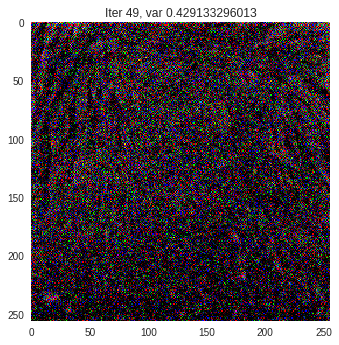

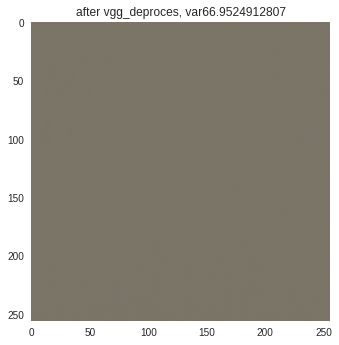

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_50_frame_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 51: dynamic texture loss: 78670808.000000 iter per/s: 0.742555 ETA: 0:05:36.675227
(fur_gram) Iteration 52: dynamic texture loss: 78640808.000000 iter per/s: 1.872162 ETA: 0:02:13.001303
(fur_gram) Iteration 53: dynamic texture loss: 78609152.000000 iter per/s: 1.876331 ETA: 0:02:12.172823
(fur_gram) Iteration 54: dynamic texture loss: 78573480.000000 iter per/s: 1.877282 ETA: 0:02:11.573205
(fur_gram) Iteration 55: dynamic texture loss: 78543736.000000 iter per/s: 1.877955 ETA: 0:02:10.993541
(fur_gram) Iteration 56: dynamic texture loss: 78510600.000000 iter per/s: 1.857514 ETA: 0:02:11.896710
(fur_gram) Iteration 57: dynamic texture loss: 78495440.000000 iter per/s: 1.870386 ETA: 0:02:10.454389
(fur_gram) Iteration 58: dynamic texture loss: 78484120.000000 iter per/s: 1.871412 ETA: 0:02:09.848479
(fur_gram) Iteration 59: dynamic texture loss: 78476040.000000 iter per/s: 1.929824 ETA: 0:02:05.400054
(fur_gram) Iteration 60: dynamic texture loss: 78451424.000000 i

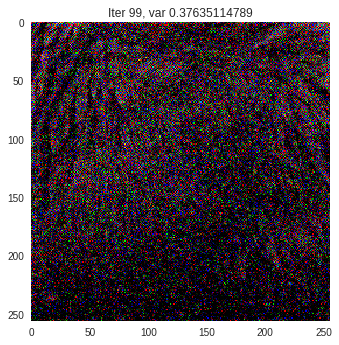

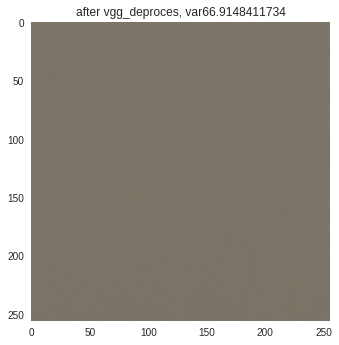

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_100_frame_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 101: dynamic texture loss: 78004016.000000 iter per/s: 0.777222 ETA: 0:04:17.326603
(fur_gram) Iteration 102: dynamic texture loss: 78002136.000000 iter per/s: 1.833208 ETA: 0:01:48.552895
(fur_gram) Iteration 103: dynamic texture loss: 77999144.000000 iter per/s: 1.769752 ETA: 0:01:51.880066
(fur_gram) Iteration 104: dynamic texture loss: 77996016.000000 iter per/s: 1.802357 ETA: 0:01:49.301337
(fur_gram) Iteration 105: dynamic texture loss: 77991088.000000 iter per/s: 1.639766 ETA: 0:01:59.529231
(fur_gram) Iteration 106: dynamic texture loss: 77986152.000000 iter per/s: 1.706939 ETA: 0:01:54.239588
(fur_gram) Iteration 107: dynamic texture loss: 77983144.000000 iter per/s: 1.735756 ETA: 0:01:51.766891
(fur_gram) Iteration 108: dynamic texture loss: 77978464.000000 iter per/s: 1.735012 ETA: 0:01:51.238444
(fur_gram) Iteration 109: dynamic texture loss: 77976056.000000 iter per/s: 1.817006 ETA: 0:01:45.668335
(fur_gram) Iteration 110: dynamic texture loss: 7797204

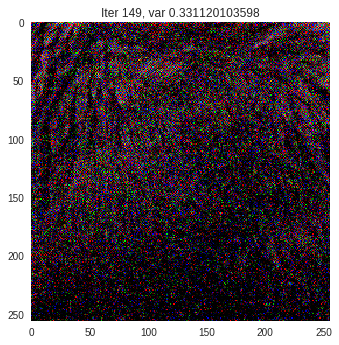

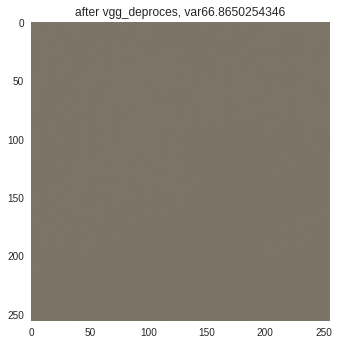

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_150_frame_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 151: dynamic texture loss: 77896152.000000 iter per/s: 0.830107 ETA: 0:03:00.699599
(fur_gram) Iteration 152: dynamic texture loss: 77895192.000000 iter per/s: 1.825550 ETA: 0:01:21.619226
(fur_gram) Iteration 153: dynamic texture loss: 77894072.000000 iter per/s: 1.858756 ETA: 0:01:19.623134
(fur_gram) Iteration 154: dynamic texture loss: 77892704.000000 iter per/s: 1.834876 ETA: 0:01:20.114415
(fur_gram) Iteration 155: dynamic texture loss: 77891360.000000 iter per/s: 1.818506 ETA: 0:01:20.285686
(fur_gram) Iteration 156: dynamic texture loss: 77890328.000000 iter per/s: 1.840811 ETA: 0:01:18.769637
(fur_gram) Iteration 157: dynamic texture loss: 77889072.000000 iter per/s: 1.839036 ETA: 0:01:18.301895
(fur_gram) Iteration 158: dynamic texture loss: 77887760.000000 iter per/s: 1.829532 ETA: 0:01:18.162076
(fur_gram) Iteration 159: dynamic texture loss: 77886832.000000 iter per/s: 1.845386 ETA: 0:01:16.948671
(fur_gram) Iteration 160: dynamic texture loss: 7788569

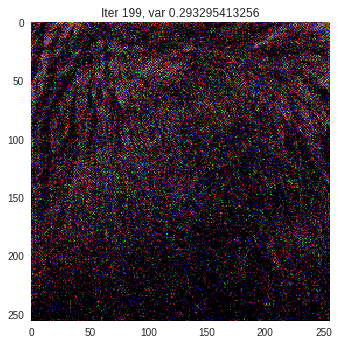

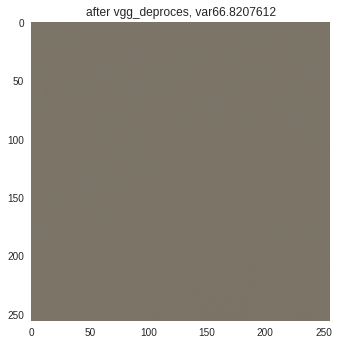

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: data/out/fur_gram/iter_200_frame_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)


(fur_gram) Iteration 201: dynamic texture loss: 77856984.000000 iter per/s: 0.816069 ETA: 0:02:02.538614
(fur_gram) Iteration 202: dynamic texture loss: 77856488.000000 iter per/s: 1.843998 ETA: 0:00:53.687699
(fur_gram) Iteration 203: dynamic texture loss: 77855824.000000 iter per/s: 1.842782 ETA: 0:00:53.180470
(fur_gram) Iteration 204: dynamic texture loss: 77855544.000000 iter per/s: 1.845049 ETA: 0:00:52.573127
(fur_gram) Iteration 205: dynamic texture loss: 77854952.000000 iter per/s: 1.842911 ETA: 0:00:52.091515
(fur_gram) Iteration 206: dynamic texture loss: 77854392.000000 iter per/s: 1.826517 ETA: 0:00:52.011561
(fur_gram) Iteration 207: dynamic texture loss: 77853840.000000 iter per/s: 1.839293 ETA: 0:00:51.106588
(fur_gram) Iteration 208: dynamic texture loss: 77853560.000000 iter per/s: 1.835917 ETA: 0:00:50.655894
(fur_gram) Iteration 209: dynamic texture loss: 77853176.000000 iter per/s: 1.841963 ETA: 0:00:49.946720
(fur_gram) Iteration 210: dynamic texture loss: 7785276

In [0]:
s.optimize()

In [0]:
# for name in sorted(os.listdir(fold_result)):
  
#   plt.figure()
#   plt.imshow(plt.imread(fold_result + '/' + name))
#   plt.title(name)
#   plt.grid(False)
